In [7]:
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
matplotlib.rcParams["figure.dpi"] = 1000
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

## Yearly data

In [5]:
xy = []
yy = []
for j in range(1976,2024):
    with open(r"Flare Index Dataset Cleaner\\"+str(j)+".txt", mode="r") as f:
        value = float(f.readlines()[-1].split("\t")[1])
        xy.append(j)
        yy.append(value)

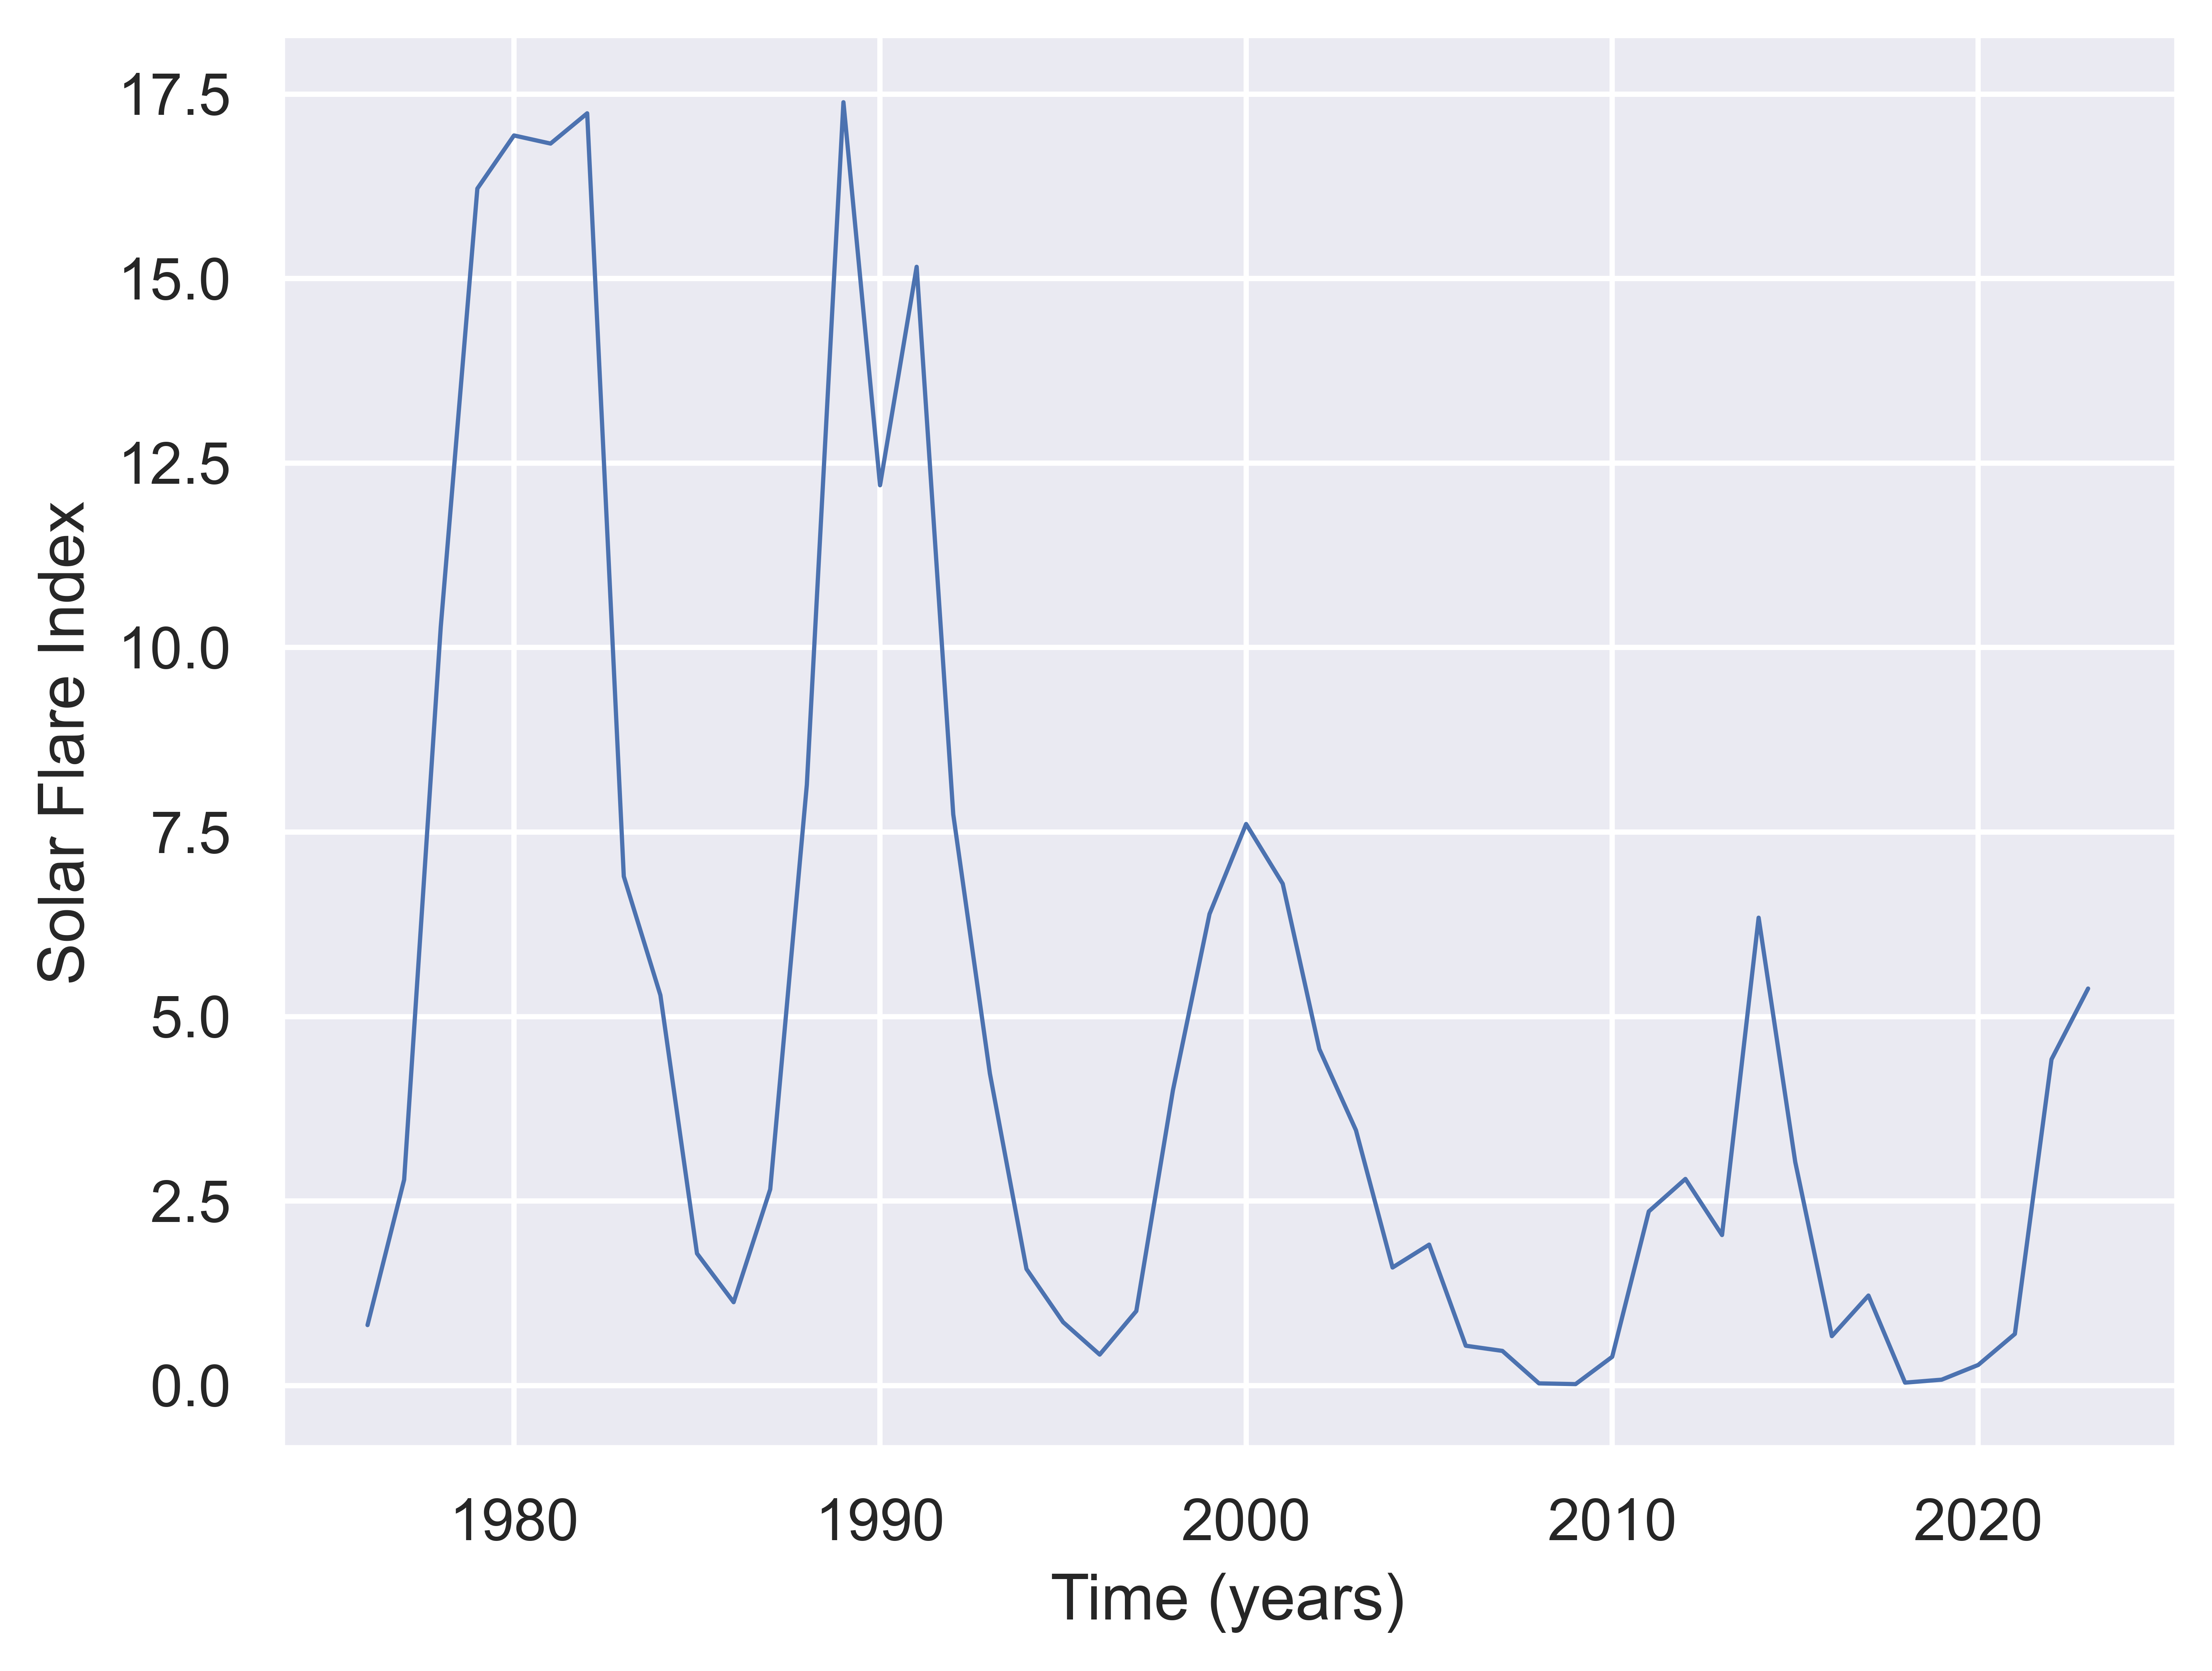

In [23]:
fig, ax = plt.subplots()
sns.lineplot(x=xy,y=yy,lw=0.8)
sns.despine()
ax.set(xlabel='Time (years)', ylabel='Solar Flare Index')
plt.savefig('yearly_variations.png', dpi=2000, bbox_inches='tight')
plt.show()

## Monthly data

In [14]:
xm = []
ym = []
for j in range(1976,2024):
    with open(r"Flare Index Dataset Cleaner\\"+str(j)+".txt", mode="r") as f:
        lines = f.readlines()
        line = lines[-3].strip()
        for v in line.split("\t")[1:]:
            ym.append(float(v))
        for i in range(12):
            xm.append(j+1.00*i/12.00)

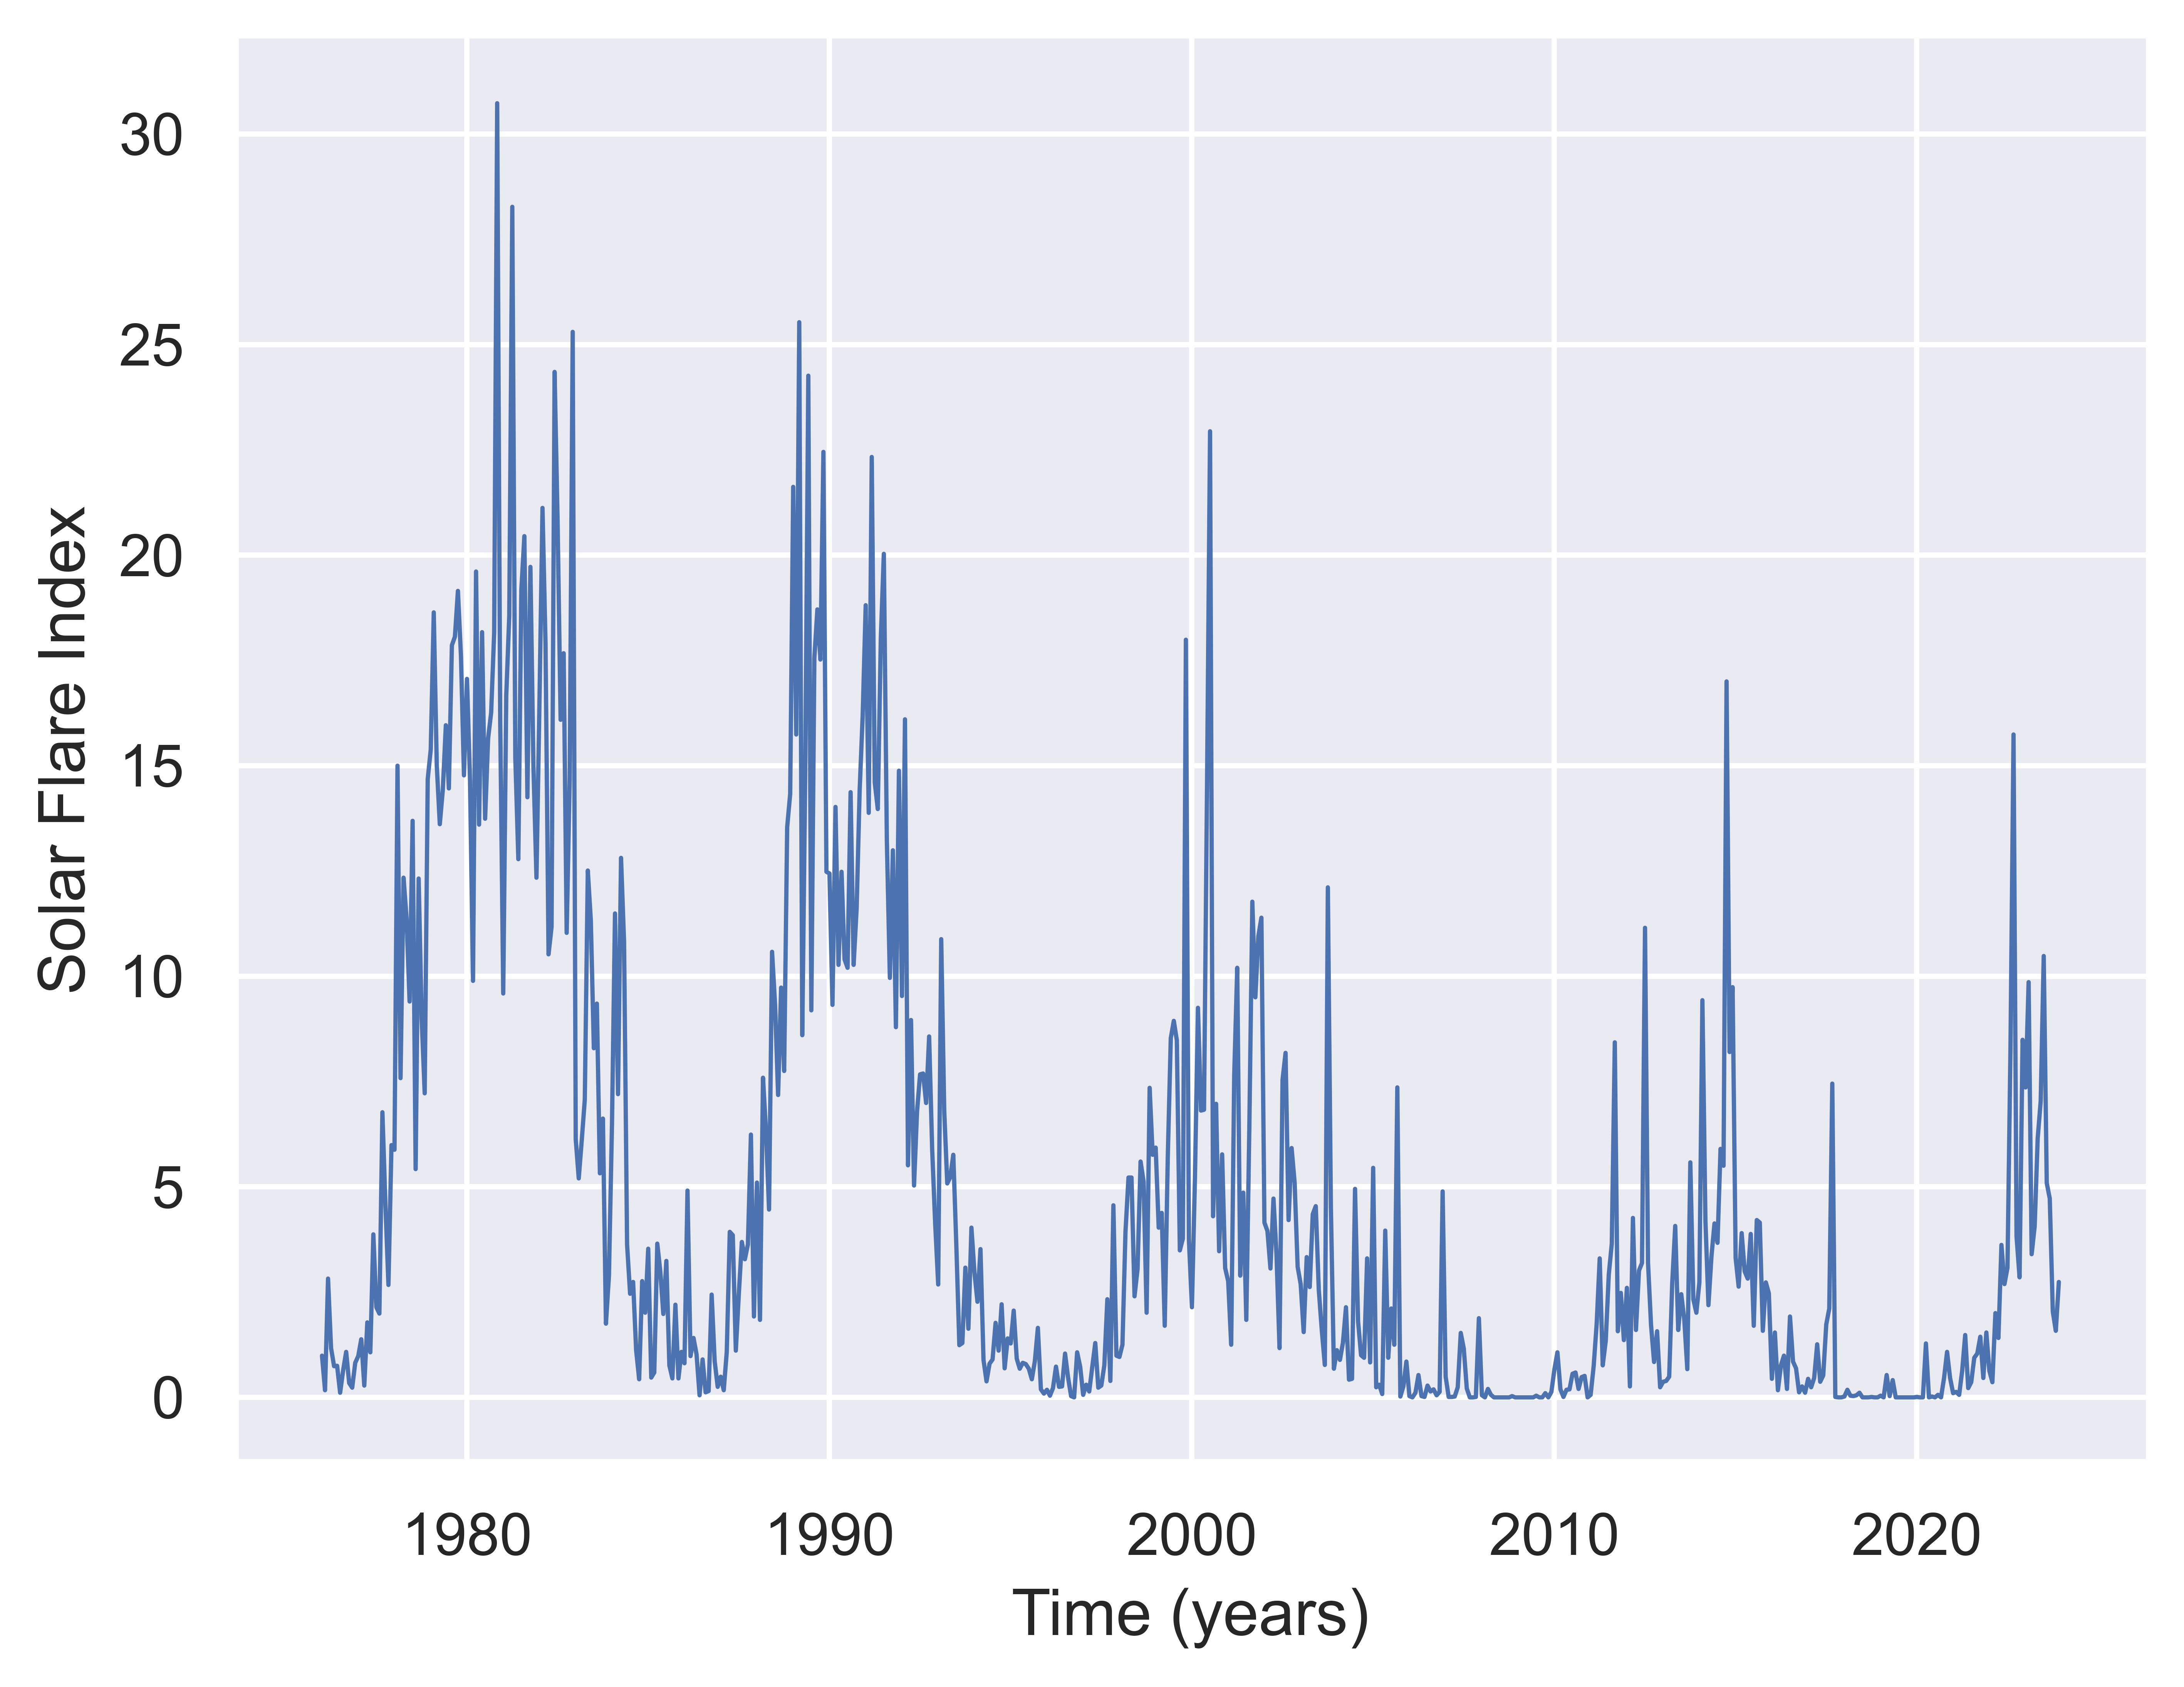

In [24]:
fig, ax = plt.subplots()
sns.lineplot(x=xm,y=ym,lw=0.8)
sns.despine()
ax.set(xlabel='Time (years)', ylabel='Solar Flare Index')
plt.savefig('monthly_variations.png', dpi=2000, bbox_inches='tight')
plt.show()

## Daily data

In [16]:
x = []
y = []
ymstd = [] #y std monthly
for j in range(1976,2024):
    with open(r"Flare Index Dataset Cleaner\\"+str(j)+".txt", mode="r") as f:
        lines = f.readlines()[7:]
        mat = []
        for line in lines[:-4]:
            if line[0] == '\n': continue
            l = line.split("\t")
            l[-1] = l[-1].strip()
            for i in range(len(l)):
                if l[i] == '': l[i] = -1
                l[i] = float(l[i])
            mat.append(l[1:13])
        mat = np.matrix(mat).transpose() #reordering
        #calculate variance and +- 1*sigma values per month
        for v in mat:
            v = v.tolist()[0]
            v = [i for i in v if i >= 0]
            ymstd.append(np.std(v))
        days = mat.flatten().tolist()[0] #turn it into a 1D array
        days = [i for i in days if i >= 0]
        ndays = len(days)
        for i in range(ndays):
            y.append(days[i])
            x.append(j+1.00*i/(ndays*1.00))

In [17]:
#extra calculations for upper and lower bounds
ns = 1 #number of sigmas. Default is 1.
yupp = np.array(ym)+ns*np.array(ymstd)
ylow = np.array(ym)-ns*np.array(ymstd)
zeros = np.ndarray(ylow.shape)
def ylowhelper(i):
    if i<0: return 0
    else: return i
vctrd = np.vectorize(ylowhelper)
ylow = vctrd(ylow)

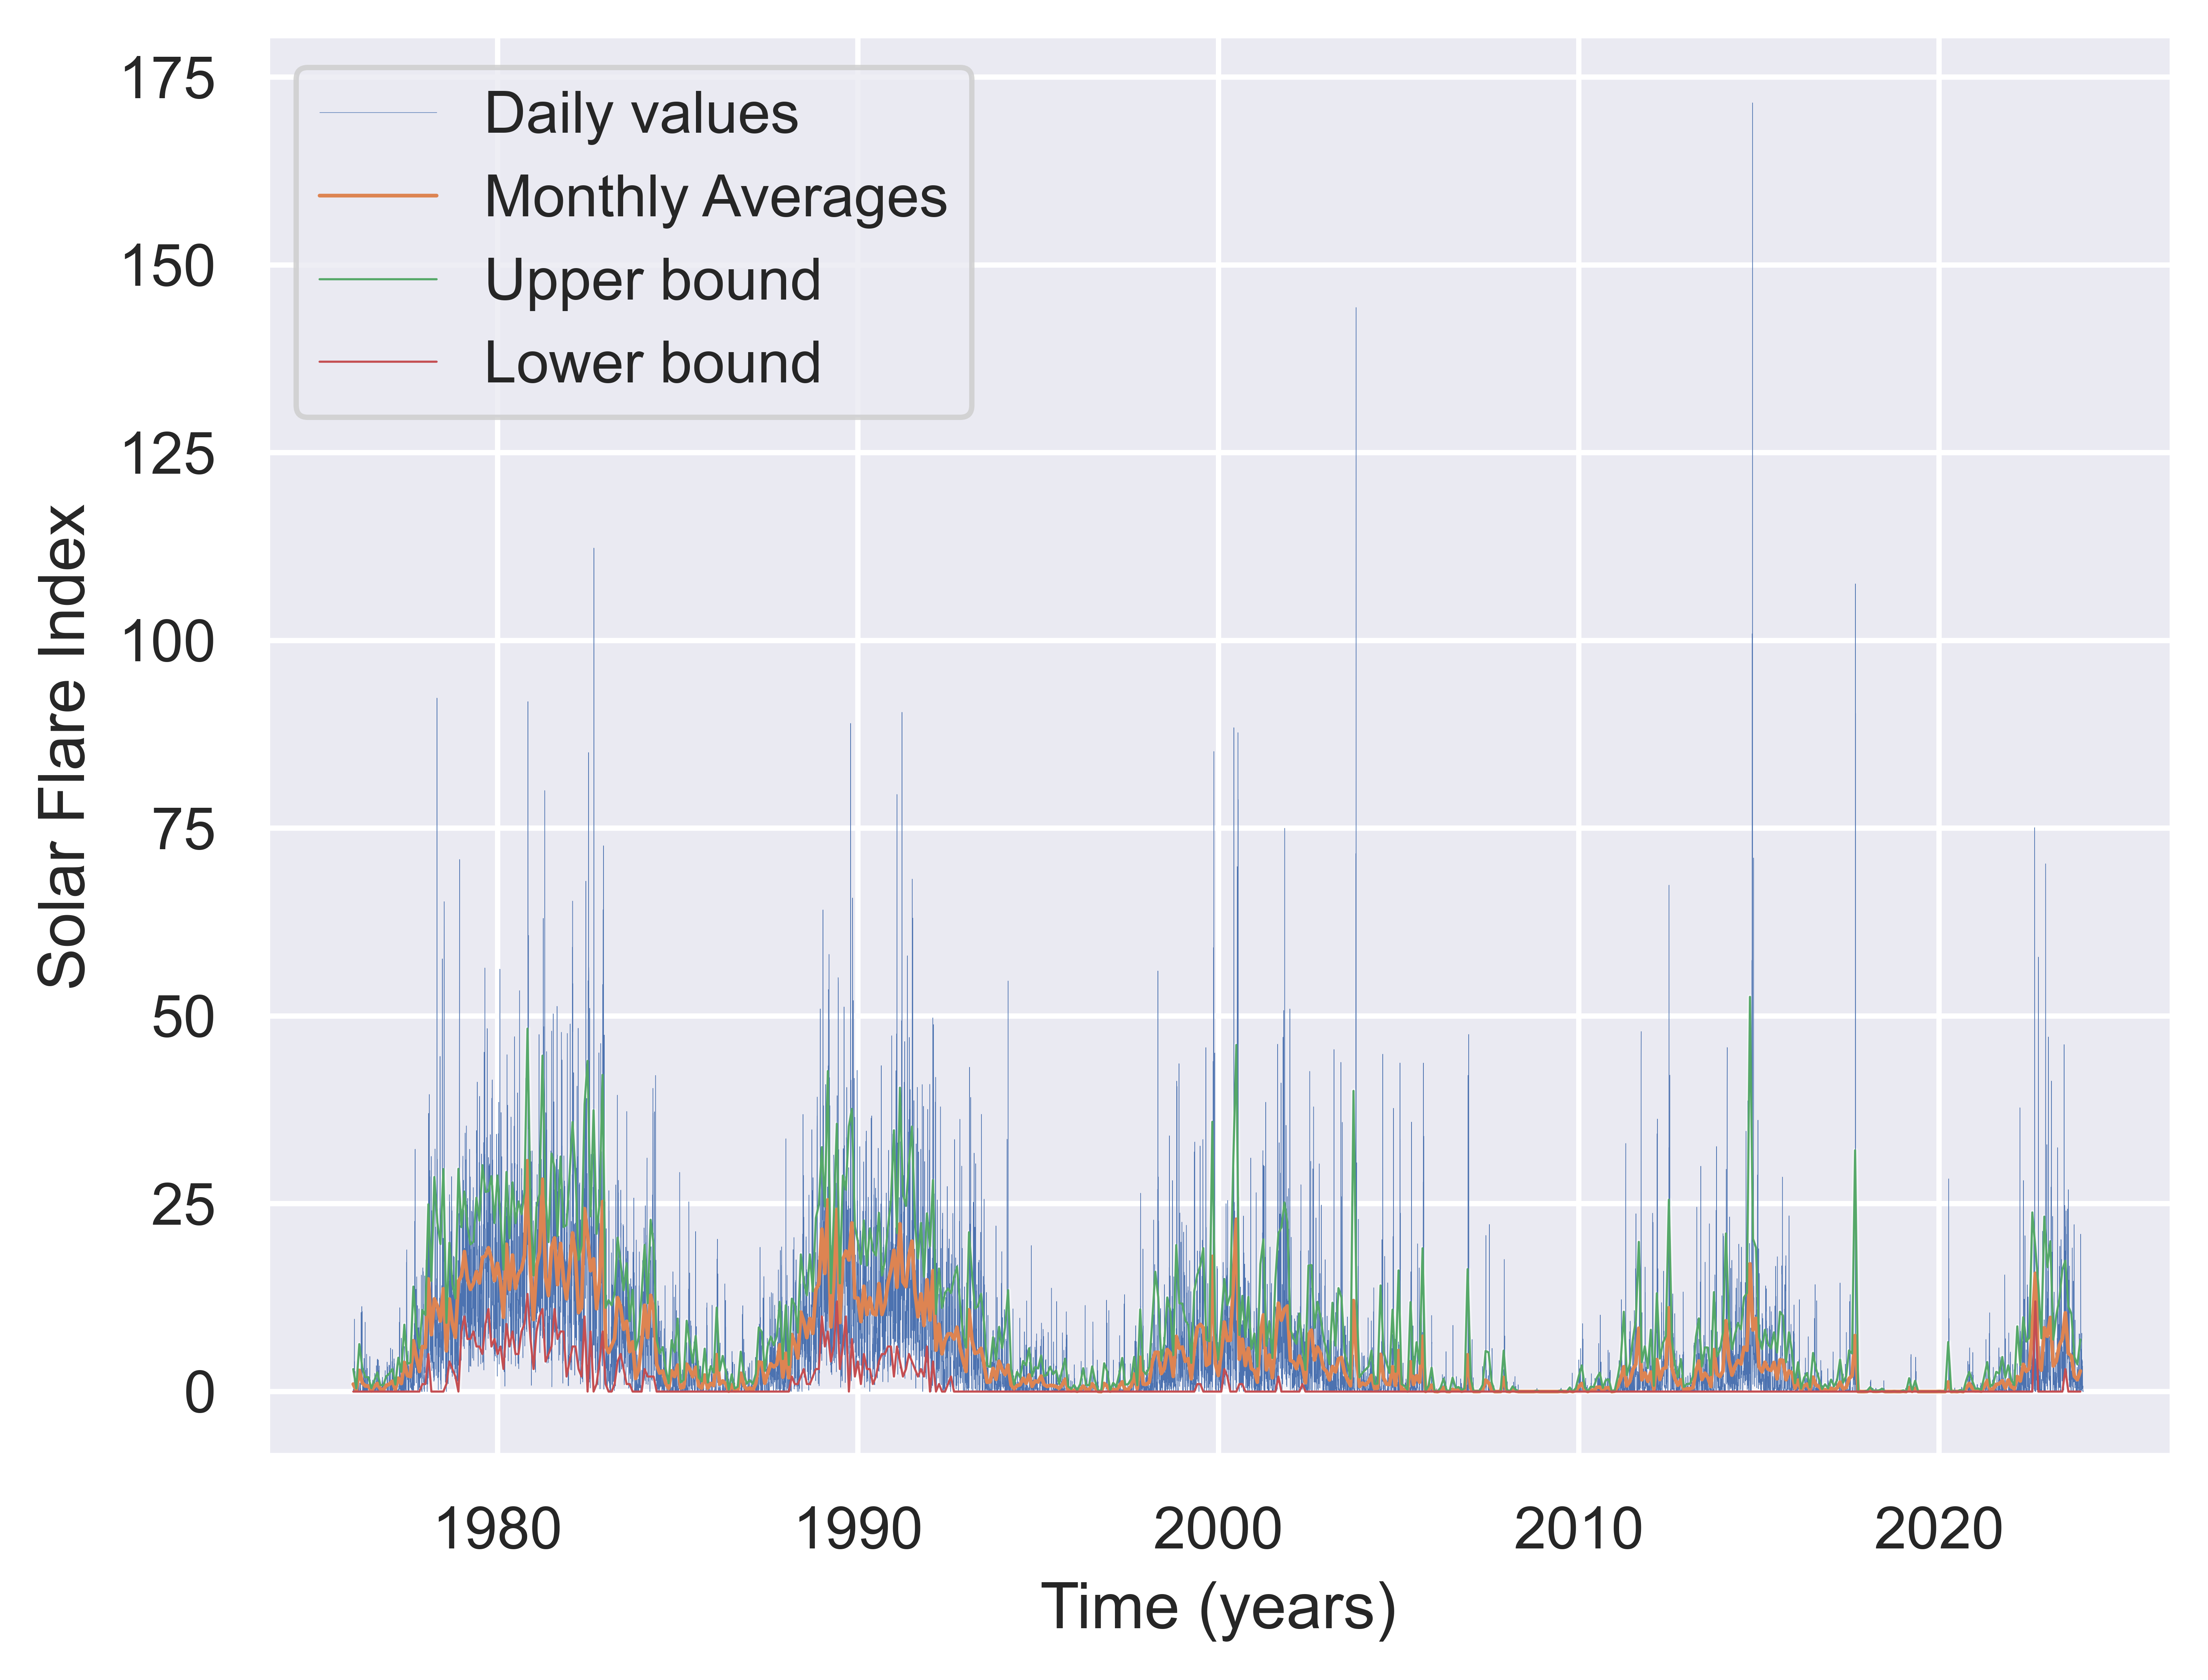

In [22]:
fig, ax = plt.subplots()
sns.lineplot(x=x,y=y,lw=0.1,label="Daily values")
sns.despine()
sns.lineplot(x=xm,y=ym,lw=0.7,label="Monthly Averages")
sns.lineplot(x=xm,y=yupp,lw=0.4,label="Upper bound")
sns.lineplot(x=xm,y=ylow,lw=0.4,label="Lower bound")
plt.fill_between(x=xm,y1=ylow,y2=yupp,color='white', alpha=0.5) #TODO
# sns.set(font_scale=1)
ax.set(xlabel='Time (years)', ylabel='Solar Flare Index')
plt.legend()
plt.savefig('daily_variations.png', dpi=2000, bbox_inches='tight')
plt.show()

## Time series modelling
### ARMA

In [208]:
# Check for stationality (Dickey-Fuller ADF test)
t = adfuller(ym)
print('ADF Statistic:', t[0])
print('p-value:', t[1]) #we obtain p>0.05, but close to it. 
#But if we look into the daily series...
t = adfuller(y)
print('ADF Statistic:', t[0])
print('p-value:', t[1]) #we obtain p<<<0.05. So we will consider ym to also be stationary.

ADF Statistic: -2.5564019461976297
p-value: 0.10234697783906815
ADF Statistic: -7.485723626428135
p-value: 4.6448248439848e-11


In [27]:
def get_loglike(v):
    b = v.as_csv().split("\n")
    b = b[2].split(",")[-1]
    return float(b)

In [59]:
model = ARIMA(ym, order=(24, 0, 2))
model_fit = model.fit()
# Print the model summary
model_fit.summary()

C:\Users\Nero\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  576
Model:                ARIMA(24, 0, 2)   Log Likelihood               -1434.025
Date:                Sun, 29 Dec 2024   AIC                           2924.050
Time:                        15:02:21   BIC                           3046.021
Sample:                             0   HQIC                          2971.617
                                - 576                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.7157      2.288      2.061      0.039       0.232       9.200
ar.L1         -0.3583      0.187     -1.915      0.055      -0.725       0.008
ar.L2         -0.1655      0.188     -0.881      0.378      -0.534       0.203
ar.L3          0.4384      0.101      4.322      0.000       0.240       0.637
ar.L4          0.2658      0.067      3.963      0.000       0.134       0.397
ar.L5          0.2905      0.062      4.660      0.000       0.168       0.413
ar.L6          0.1212      0.058      2.095      0.036       0.008       0.235
ar.L7          0.0570      0.053      1.071      0.284      -0.047       0.161
ar.L8          0.1307      0.046      2.841      0.004       0.041       0.221
ar.L9          0.1004      0.054      1.848      0.065      -0.006       0.207
ar.L10         0.1959      0.059      3.341      0.001       0.081       0.311
ar.L11         0.0233      0.060      0.387      0.699      -0.094       0.141
ar.L12         0.0195      0.055      0.353      0.724      -0.089       0.128
ar.L13        -0.2147      0.052     -4.161      0.000      -0.316      -0.114
ar.L14        -0.0182      0.064     -0.283      0.777      -0.144       0.108
ar.L15        -0.0313      0.056     -0.555      0.579      -0.142       0.079
ar.L16         0.1381      0.055      2.502      0.012       0.030       0.246
ar.L17         0.0164      0.056      0.295      0.768      -0.093       0.126
ar.L18        -0.0579      0.056     -1.040      0.298      -0.167       0.051
ar.L19         0.0054      0.059      0.091      0.927      -0.110       0.121
ar.L20        -0.0046      0.052     -0.088      0.930      -0.105       0.096
ar.L21         0.0611      0.051      1.192      0.233      -0.039       0.162
ar.L22        -0.0070      0.050     -0.140      0.889      -0.104       0.090
ar.L23        -0.0312      0.046     -0.678      0.498      -0.121       0.059
ar.L24        -0.1517      0.047     -3.241      0.001      -0.244      -0.060
ma.L1          0.7224      0.190      3.804      0.000       0.350       1.095
ma.L2          0.5579      0.220      2.537      0.011       0.127       0.989
sigma2         8.4685      0.338     25.079      0.000       7.807       9.130
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               517.61
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.33   Skew:                             0.99
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [60]:
print(get_loglike(model_fit.summary()))

-1434.025


In [61]:
def generate_months_pred(n,last_date):
    months_pred = n
    start = len(ym)
    end = start + months_pred-1
    xpred = []
    for i in range(months_pred):
        xpred.append(last_date+i/12)
    return xpred

In [62]:
ARMATIME = 6*12
predictions = model_fit.predict(start=len(ym), end=len(ym)+ARMATIME-1)

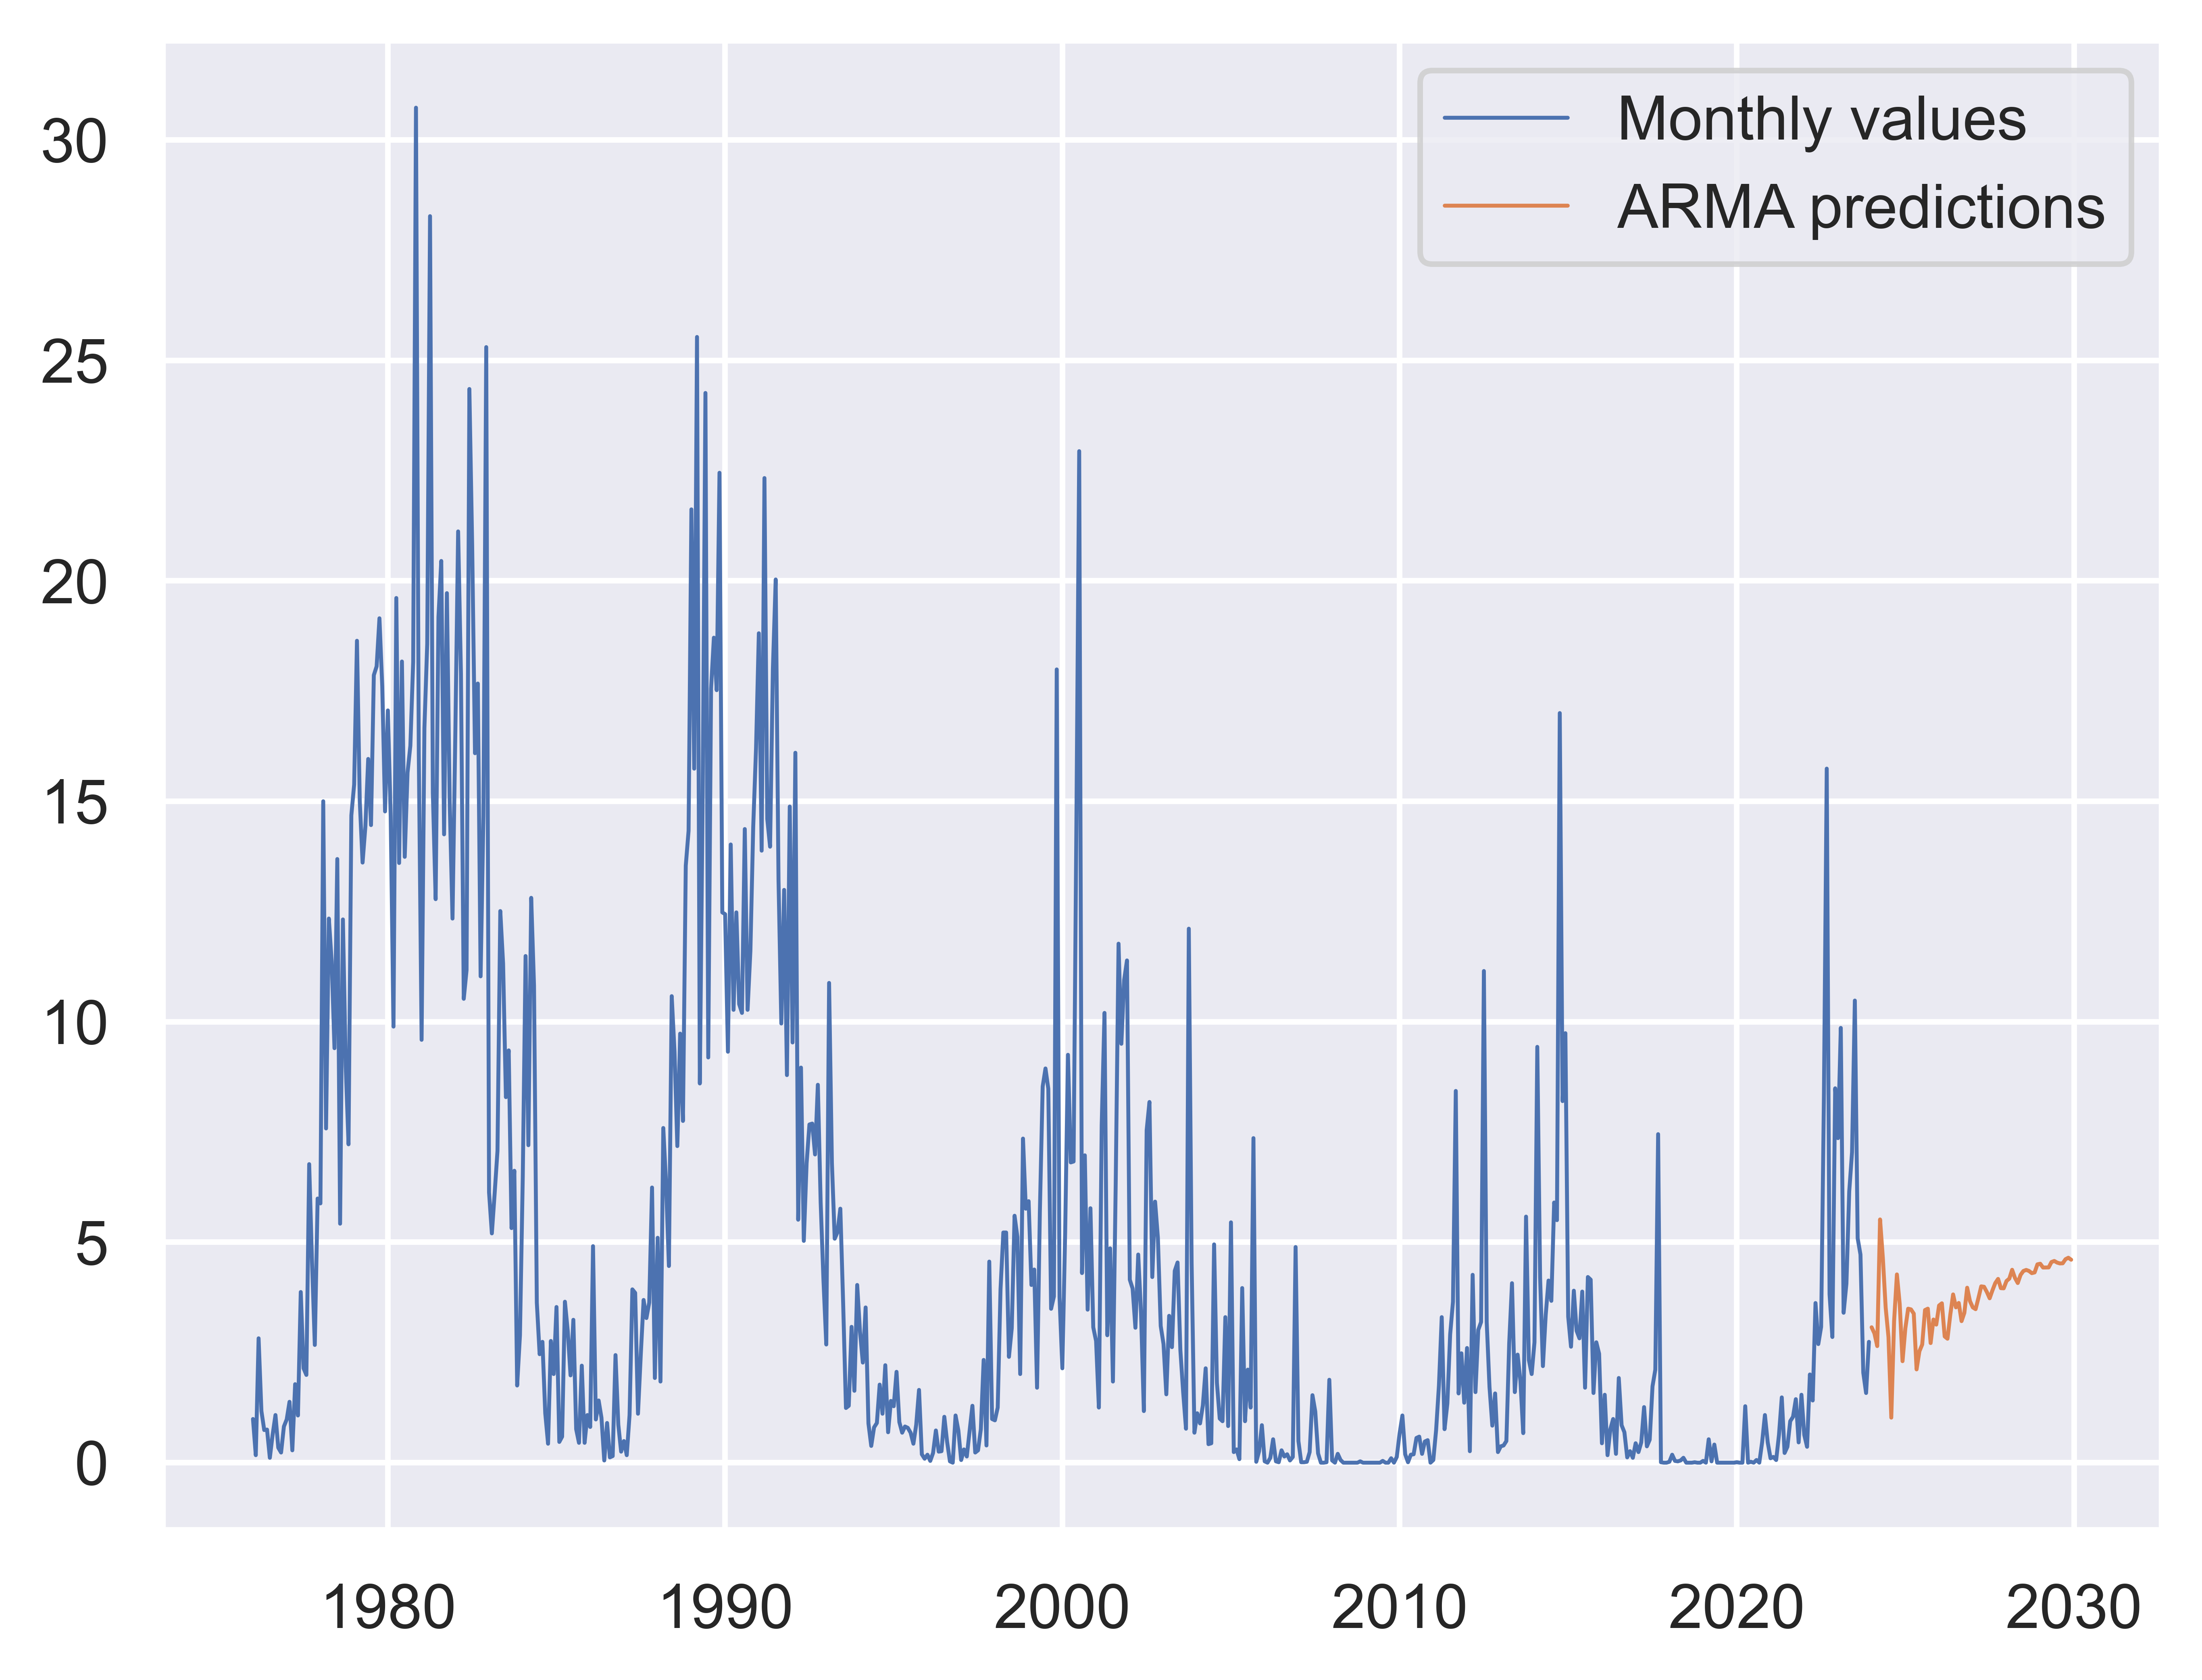

In [64]:
sns.lineplot(x=xm,y=ym,lw=0.7,label="Monthly values")
xpred = generate_months_pred(ARMATIME,x[-1])
sns.lineplot(x=xpred,y=predictions,lw=0.7,label="ARMA predictions")
ax.set(xlabel='Time (years)', ylabel='Solar Flare Index')
plt.legend()
plt.savefig('ARMA.png', dpi=2000, bbox_inches='tight')
plt.show()

### SARIMA

In [310]:
p, d, q = 1, 1, 1
P, D, Q, s = 1, 1, 1, 12*11  # Assuming 11 year seasonality

# Fit the SARIMA model
model = SARIMAX(ym, order=(p, d, q), seasonal_order=(P, D, Q, s))
results = model.fit()
model

C:\Users\Nero\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


In [311]:
print(results.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  576
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 132)   Log Likelihood               -1223.597
Date:                             Fri, 27 Dec 2024   AIC                           2457.195
Time:                                     17:00:41   BIC                           2477.663
Sample:                                          0   HQIC                          2465.267
                                             - 576                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1277      0.048      2.651      0.008       0.033       0.222
ma.L1         -0.7807      

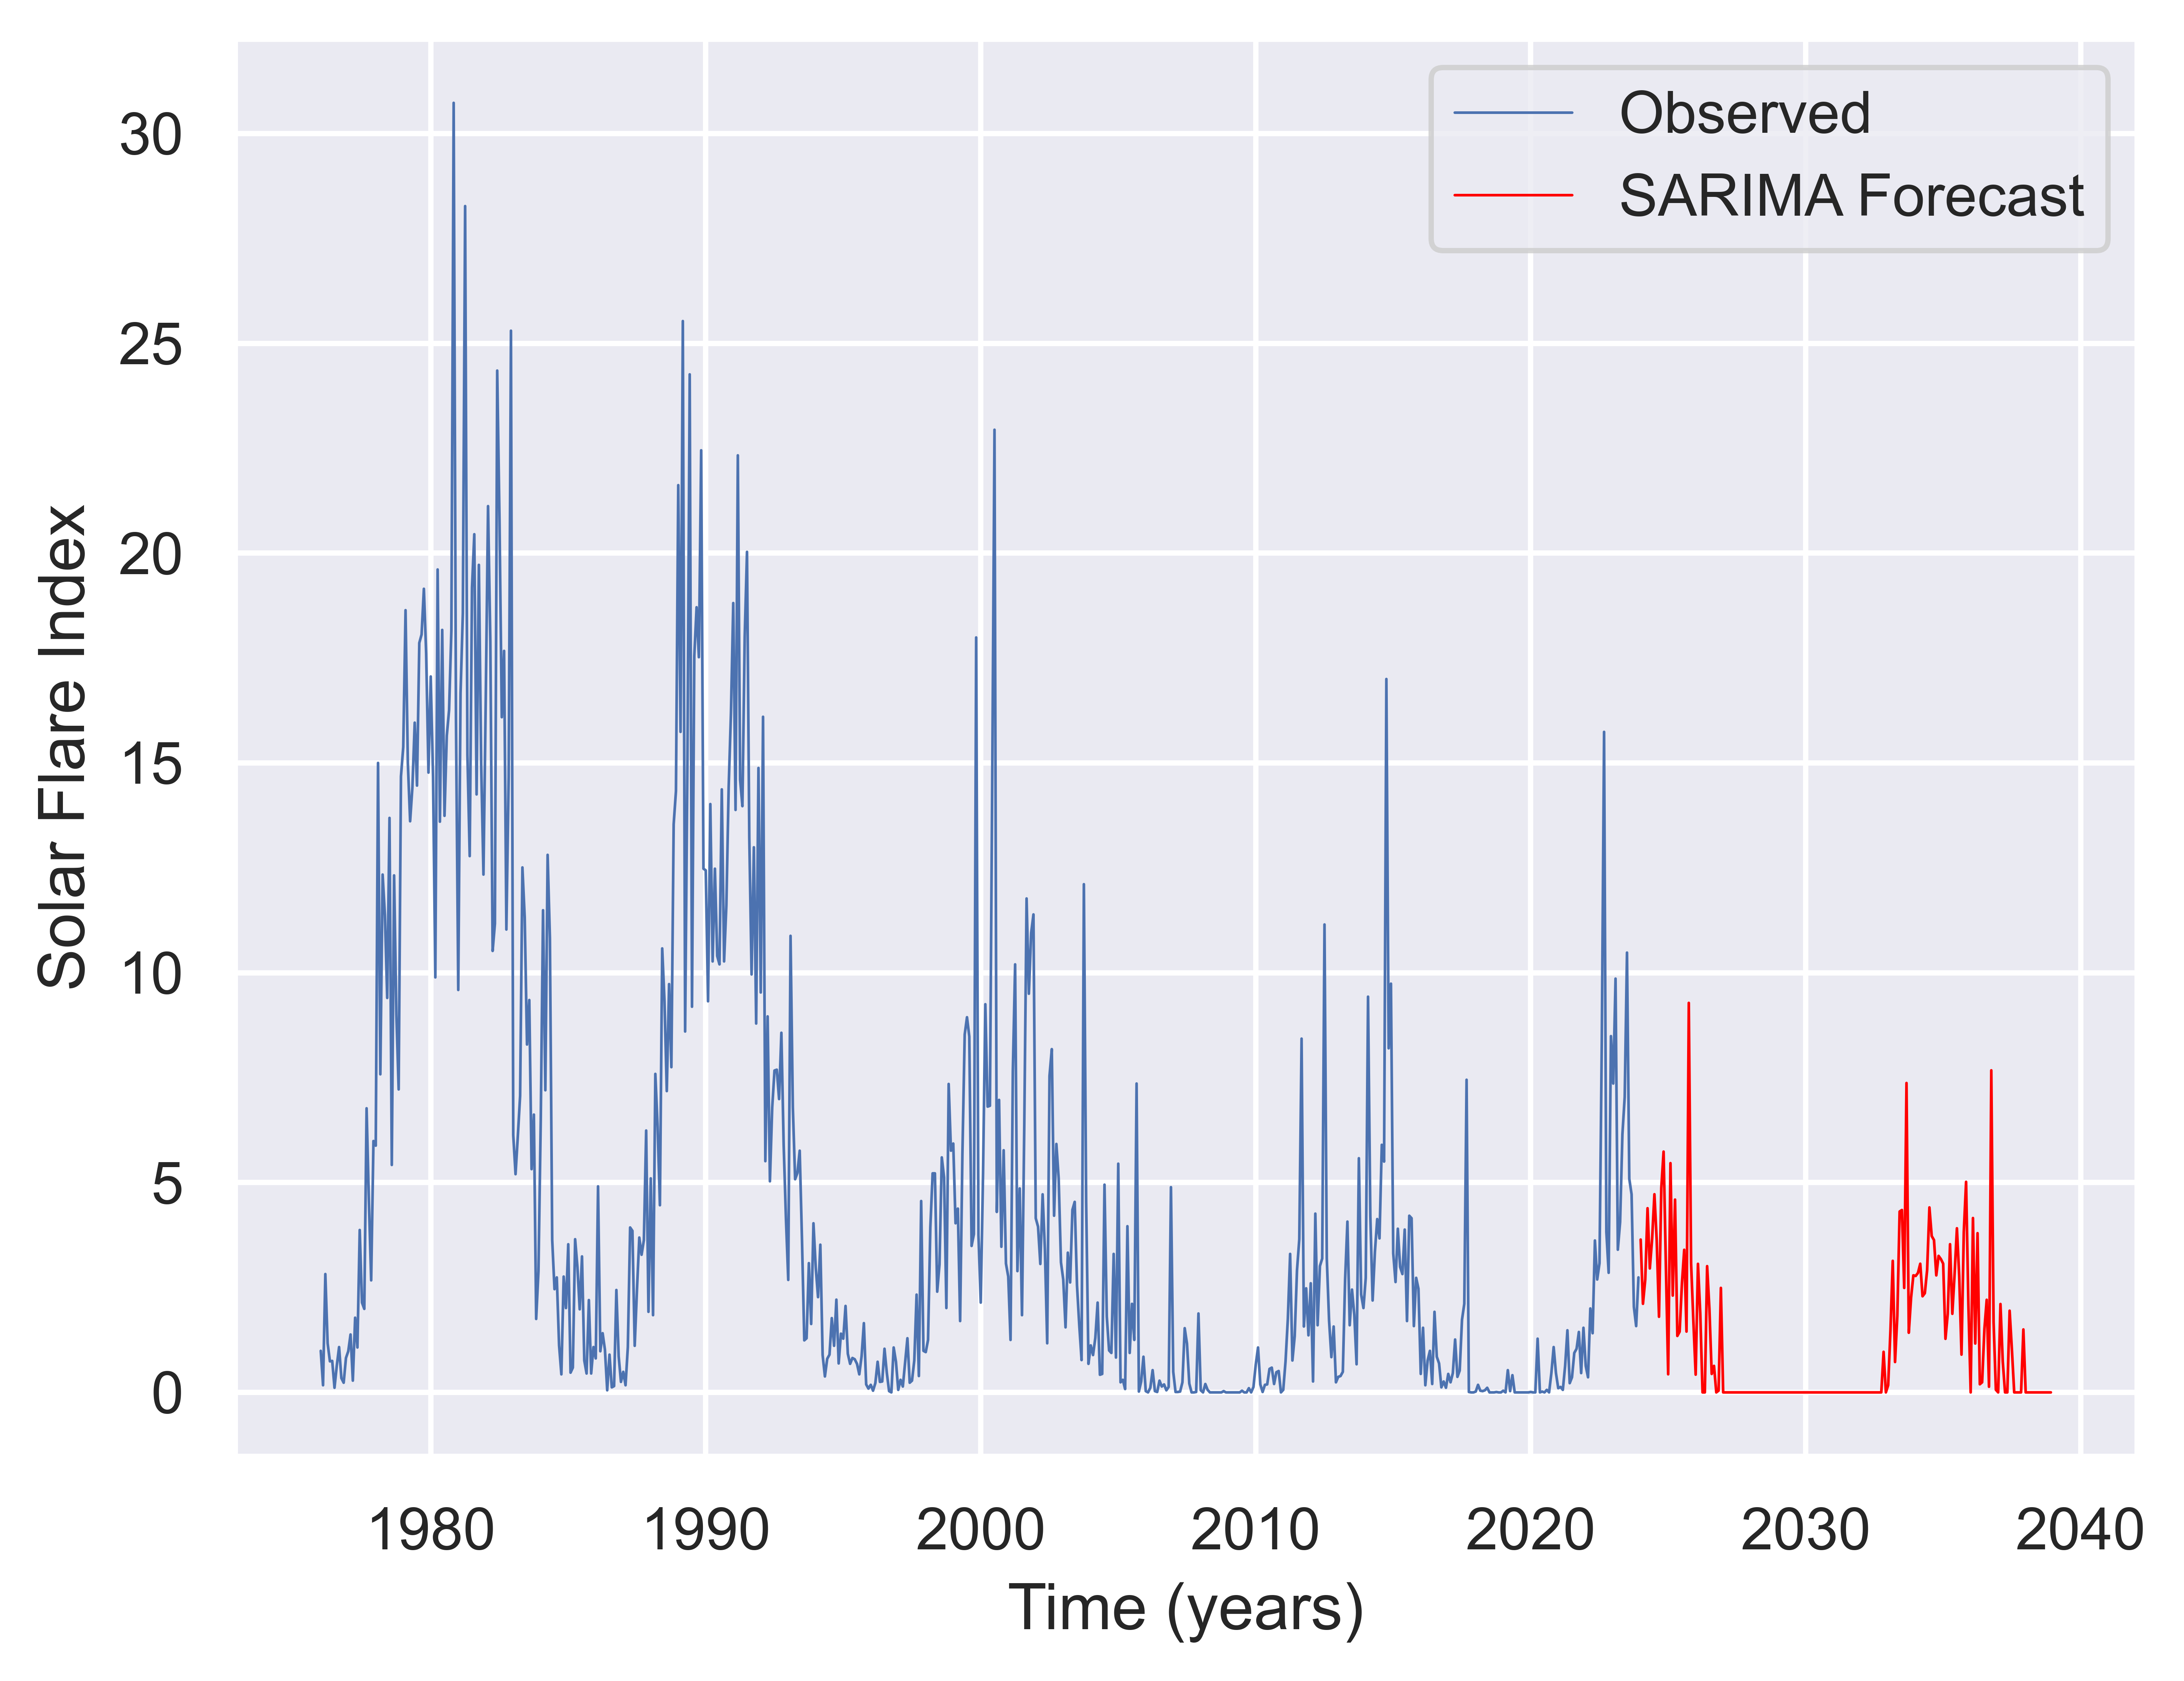

In [426]:
# Forecast future values
forecast_periods = 12*15  # Forecast the next 15 years
forecast = results.get_forecast(steps=forecast_periods)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()
fclow = vctrd(forecast_ci.transpose()[0])
fcupp = forecast_ci.transpose()[1]

xmnew = generate_months_pred(forecast_periods, x[-1])

# Plot the forecast
fig, ax = plt.subplots()
sns.lineplot(x=xm, y=ym, label='Observed',lw=0.5)
sns.lineplot(x=xmnew, y=vctrd(forecast_mean), label='SARIMA Forecast', color='red',lw=0.5)
#plt.fill_between(xmnew, fclow, fcupp, color='pink')
ax.set(xlabel='Time (years)', ylabel='Solar Flare Index')
plt.legend()
plt.savefig('SARIMA.png', dpi=2000, bbox_inches='tight')
plt.show()

## Mathematical model approximation

In [428]:
def mat_model(xi):
    #args1
    A=7.5
    w=11
    off=1976
    off2=6.3
    #args2
    w2=w*8
    A2=0.5
    B2=0.2
    off3=-6
    #overall
    alpha = 1/16
    return alpha*((A+np.cos((xi-off+off2)*2*np.pi/w)*A)**2)*(B2+A2+np.cos((xi-off+off3)*2*np.pi/w2)*A2)
v2 = np.vectorize(mat_model)

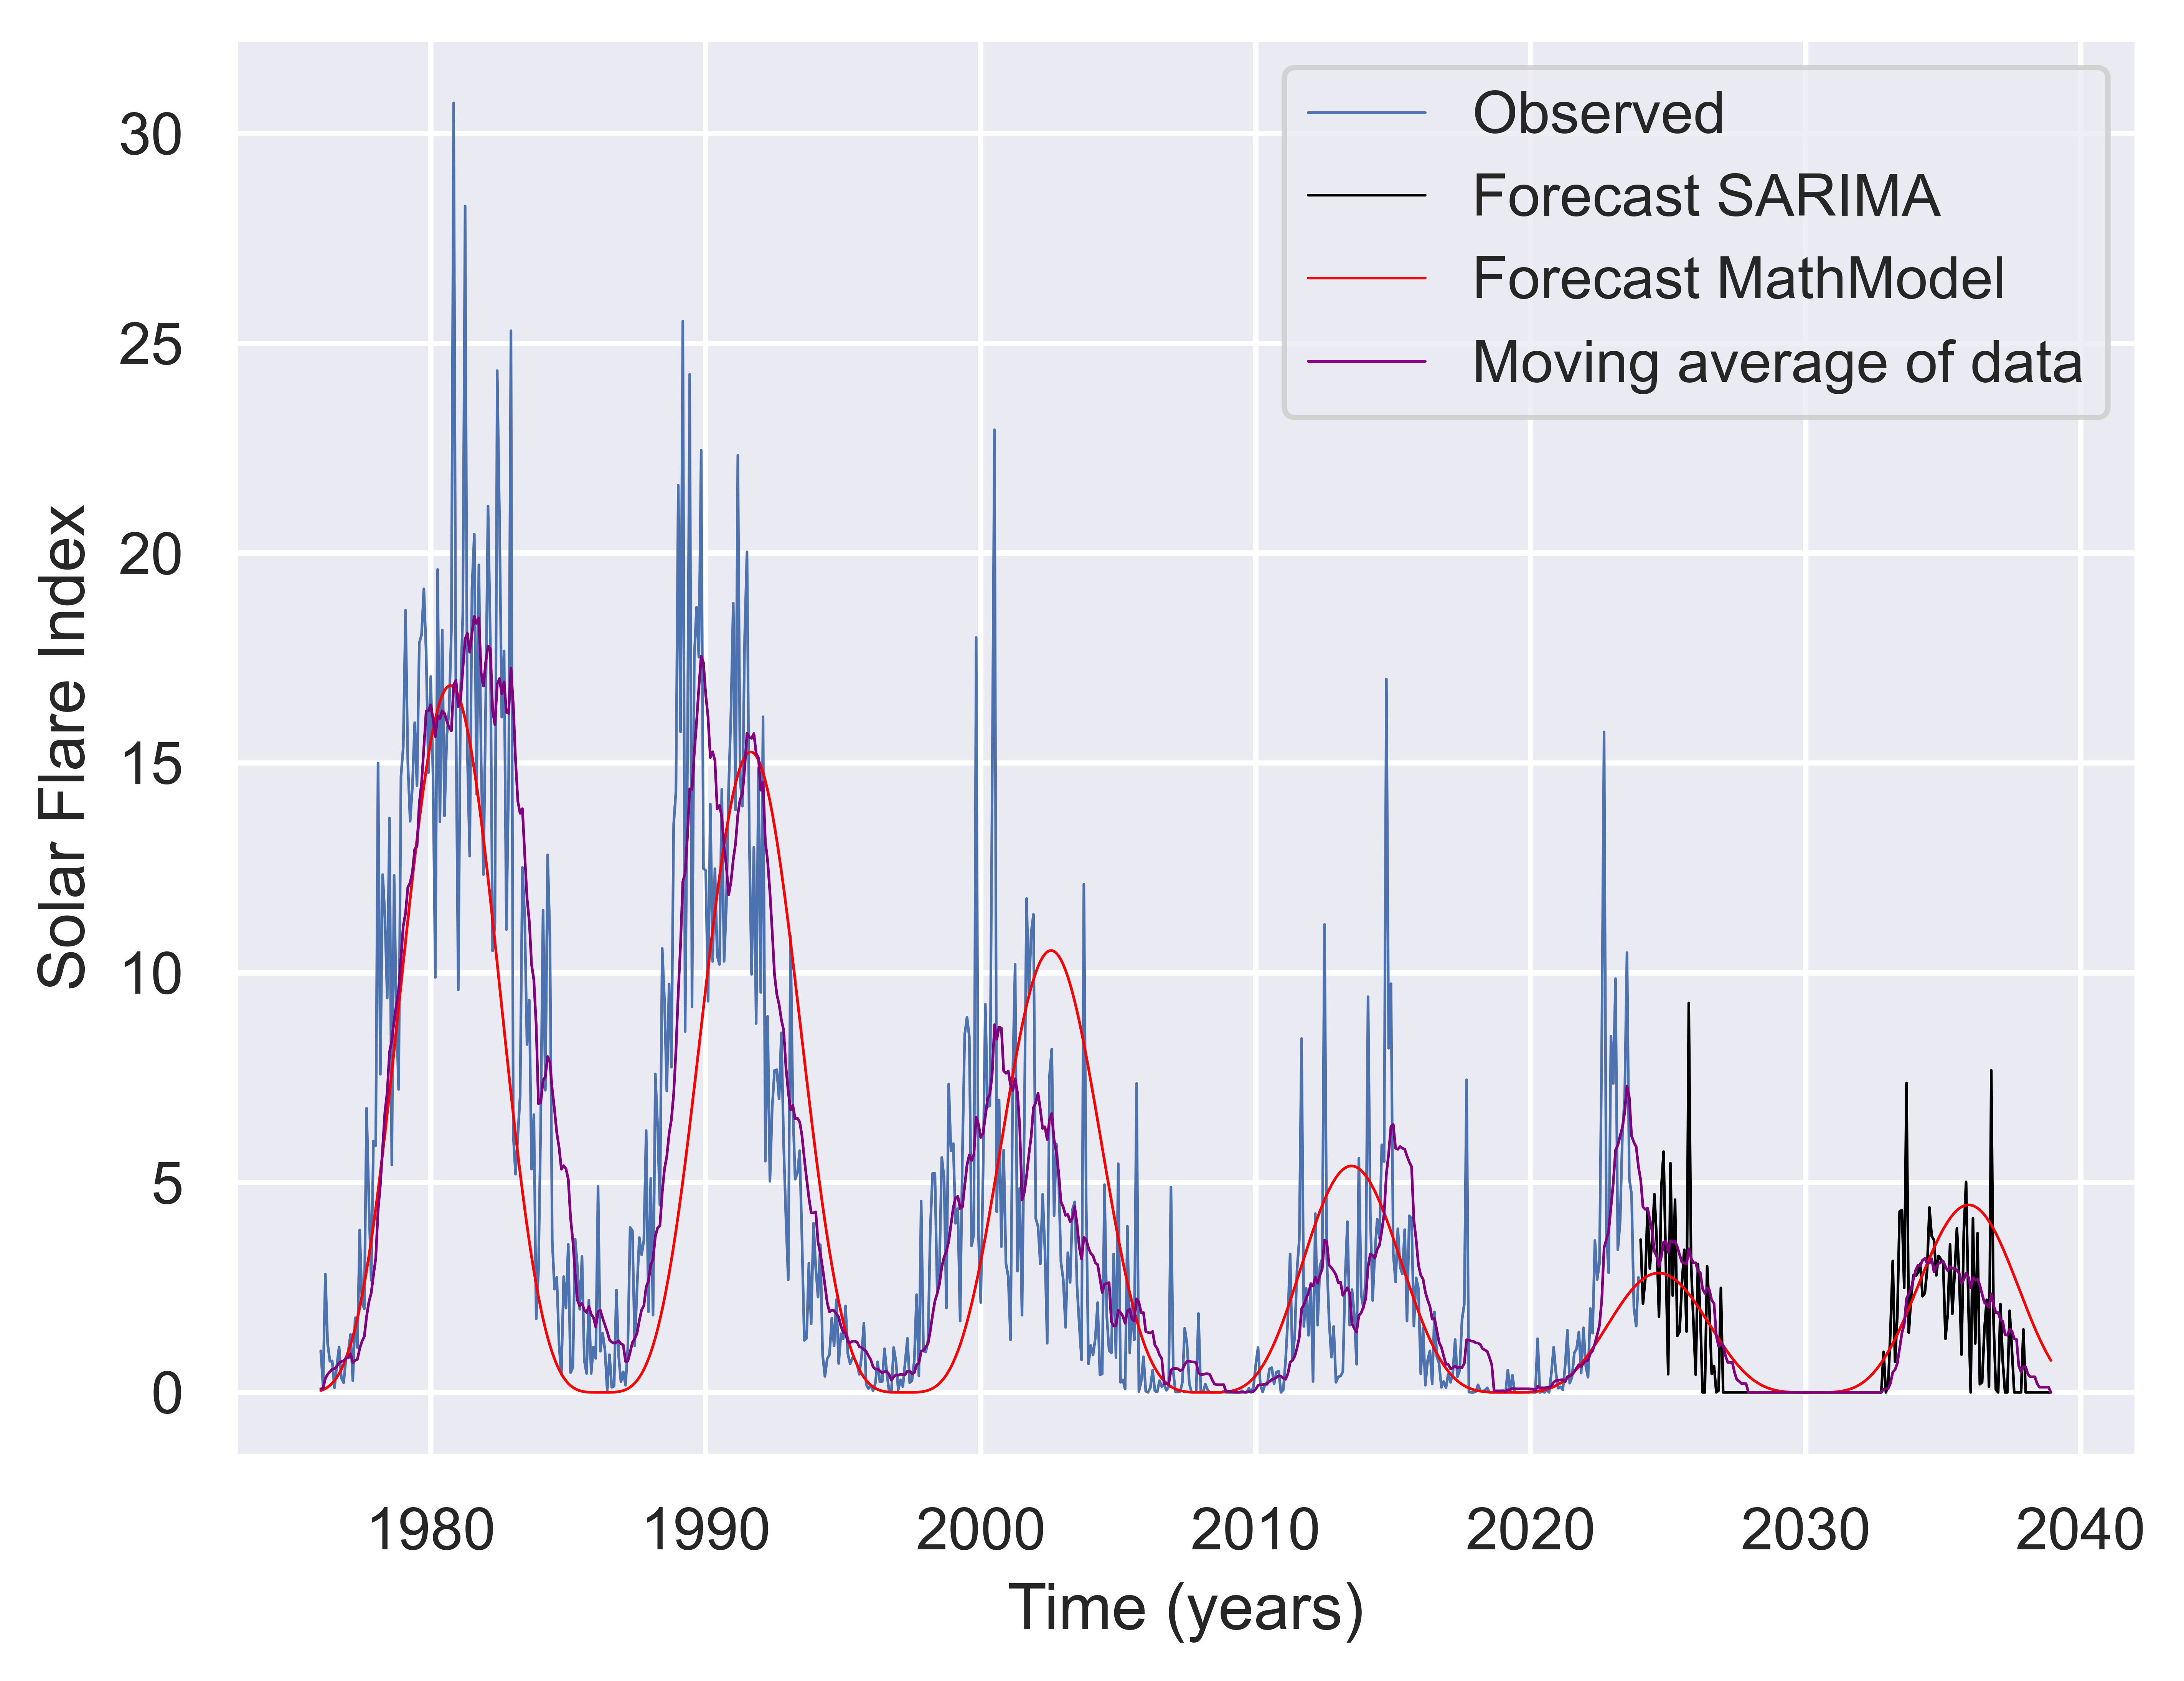

In [429]:
# Plot everything together
fig, ax = plt.subplots()
sns.lineplot(x=xm, y=ym, label='Observed',lw=0.5)
sns.lineplot(x=xmnew, y=vctrd(forecast_mean), label='Forecast SARIMA', color='black',lw=0.5)
sns.lineplot(x=xm+xmnew, y=v2(xm+xmnew), label='Forecast MathModel', color='red',lw=0.5)
MA_size=12
sns.lineplot(x=(xm+xmnew), y=np.convolve(ym+vctrd(forecast_mean).tolist(),np.ones(MA_size)/MA_size)[:-MA_size+1], label='Moving average of data', color='purple',lw=0.5)
#plt.fill_between(xmnew, fclow, fcupp, color='pink')
ax.set(xlabel='Time (years)', ylabel='Solar Flare Index')
plt.legend()
plt.savefig('MathModel.png', dpi=2000, bbox_inches='tight')
plt.show()

In [390]:
print(len(np.convolve(v2(xm+xmnew),np.ones(6)/6)[:-5]))
print(len(xm+xmnew))

756
756
